In [5]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import torch

In [6]:
def load_meta(meta_csv):
    """
    Load VinDr meta CSV with columns: image_id, dim0, dim1
    Returns dict: image_id -> (orig_height, orig_width)
    """
    df = pd.read_csv(meta_csv)
    return {r["image_id"]: (int(r["dim0"]), int(r["dim1"])) for _, r in df.iterrows()}


def visualize_heatmaps_and_gt_per_label(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # OPTIONAL
    alpha: float = 0.45,
    cmap: str = "inferno",
    only_labels=None,
    max_cols: int = 4,      # NEW: max number of columns in the grid
):
    """
    For a given VinDr image:
      - Plot heatmap + GT bounding box *per label instance* in a single grid figure.
      - Always SHOW the combined figure.
      - SAVE ONLY if save_dir is provided.

    If image has K GT boxes (after filtering), we create a grid with K subplots.
    """

    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    rows = rows.reset_index(drop=True)
    num_boxes = len(rows)

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Prepare grid layout ------------------
    n_cols = min(num_boxes, max_cols)
    n_rows = int(np.ceil(num_boxes / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows),
    )
    # Make axes iterable even if single subplot
    axes = np.array(axes).reshape(-1)

    # ------------------ Iterate Over GT Boxes ------------------
    for k, (_, r) in enumerate(rows.iterrows()):
        ax = axes[k]
        label = r["class_name"]

        if label not in heatmaps_np:
            ax.axis("off")
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Draw on subplot ------------------
        ax.imshow(img)
        ax.imshow(heatmap, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )
        ax.set_title(f"{label}")
        ax.axis("off")

    # Hide any unused axes (if n_rows * n_cols > num_boxes)
    for j in range(num_boxes, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"{image_id} — all GT boxes", fontsize=14)
    plt.tight_layout()
    plt.show()

    # SAVE OPTIONAL — single combined figure
    if save_dir is not None:
        out_name = f"{image_id}_all_labels_grid.png"
        out_path = save_dir / out_name
        fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
        print(f"[Saved] {out_path}")

    plt.close(fig)


def visualize_heatmaps_and_gt_per_label_percentile(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # OPTIONAL
    alpha: float = 0.45,
    cmap: str = "jet",      # high values → red
    only_labels=None,
    percentile: float = None,  # e.g. 95.0 => show top 5% activations
    max_cols: int = 4,         # NEW: max number of columns in the grid
):
    """
    For a given VinDr image:
      - Plot (optionally thresholded) heatmap + GT bounding box *per label instance*
        in a single grid figure.
      - Always SHOW the combined figure.
      - SAVE ONLY if save_dir is provided.

    If `percentile` is not None (e.g. 95.0), we:
      - compute threshold T = percentile(heatmap),
      - set values < T to 0,
      - keep values >= T and re-normalize them to [0,1],
      - so the hottest regions appear red with a 'jet' colormap.
    """

    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    rows = rows.reset_index(drop=True)
    num_boxes = len(rows)

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Prepare grid layout ------------------
    n_cols = min(num_boxes, max_cols)
    n_rows = int(np.ceil(num_boxes / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows),
    )
    axes = np.array(axes).reshape(-1)

    # ------------------ Iterate Over GT Boxes ------------------
    for k, (_, r) in enumerate(rows.iterrows()):
        ax = axes[k]
        label = r["class_name"]

        if label not in heatmaps_np:
            ax.axis("off")
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Top-percentile continuous heatmap ------------------
        if percentile is not None:
            thr = np.percentile(heatmap, percentile)
            hm_clipped = np.copy(heatmap)
            hm_clipped[heatmap < thr] = 0.0

            max_val = hm_clipped.max()
            if max_val > 0:
                hm_clipped = hm_clipped / max_val
            hm_to_show = hm_clipped
        else:
            hm_to_show = heatmap

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Draw on subplot ------------------
        ax.imshow(img)
        ax.imshow(hm_to_show, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )

        title_suffix = f" (top {percentile}%)" if percentile is not None else ""
        ax.set_title(f"{label}{title_suffix}")
        ax.axis("off")

    # Hide unused axes
    for j in range(num_boxes, len(axes)):
        axes[j].axis("off")

    title_suffix_global = f" — top {percentile}%" if percentile is not None else ""
    fig.suptitle(f"{image_id}{title_suffix_global}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # SAVE OPTIONAL — combined figure
    if save_dir is not None:
        out_name = f"{image_id}_all_labels_grid"
        if percentile is not None:
            out_name += f"_top{int(percentile)}"
        out_name += ".png"

        out_path = save_dir / out_name
        fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
        print(f"[Saved] {out_path}")

    plt.close(fig)

In [7]:
annotations_csv = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv")
meta_csv = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv")
heatmaps_root = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_crossattn")

[WARN] No heatmap for label 'Calcification' → skipping.
[WARN] No heatmap for label 'ILD' → skipping.
[WARN] No heatmap for label 'Pneumothorax' → skipping.
[WARN] No heatmap for label 'Pneumothorax' → skipping.
[WARN] No heatmap for label 'Atelectasis' → skipping.
[WARN] No heatmap for label 'Pneumothorax' → skipping.


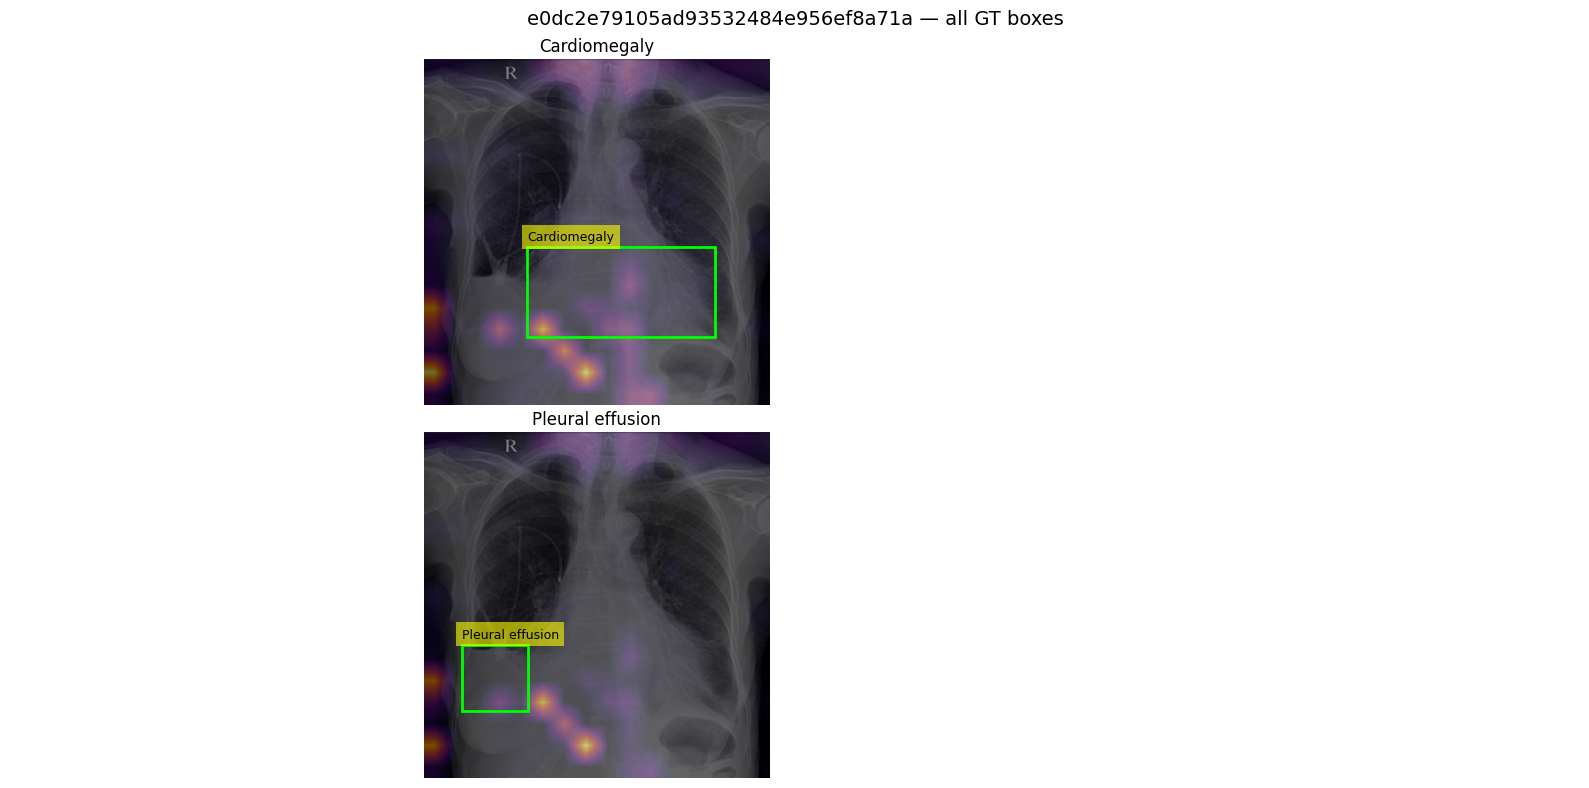

In [8]:
visualize_heatmaps_and_gt_per_label(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv=annotations_csv,
    meta_csv=meta_csv,
    heatmaps_root=heatmaps_root,
)

[WARN] No heatmap for label 'Calcification' → skipping.
[WARN] No heatmap for label 'ILD' → skipping.
[WARN] No heatmap for label 'Pneumothorax' → skipping.
[WARN] No heatmap for label 'Pneumothorax' → skipping.
[WARN] No heatmap for label 'Atelectasis' → skipping.
[WARN] No heatmap for label 'Pneumothorax' → skipping.


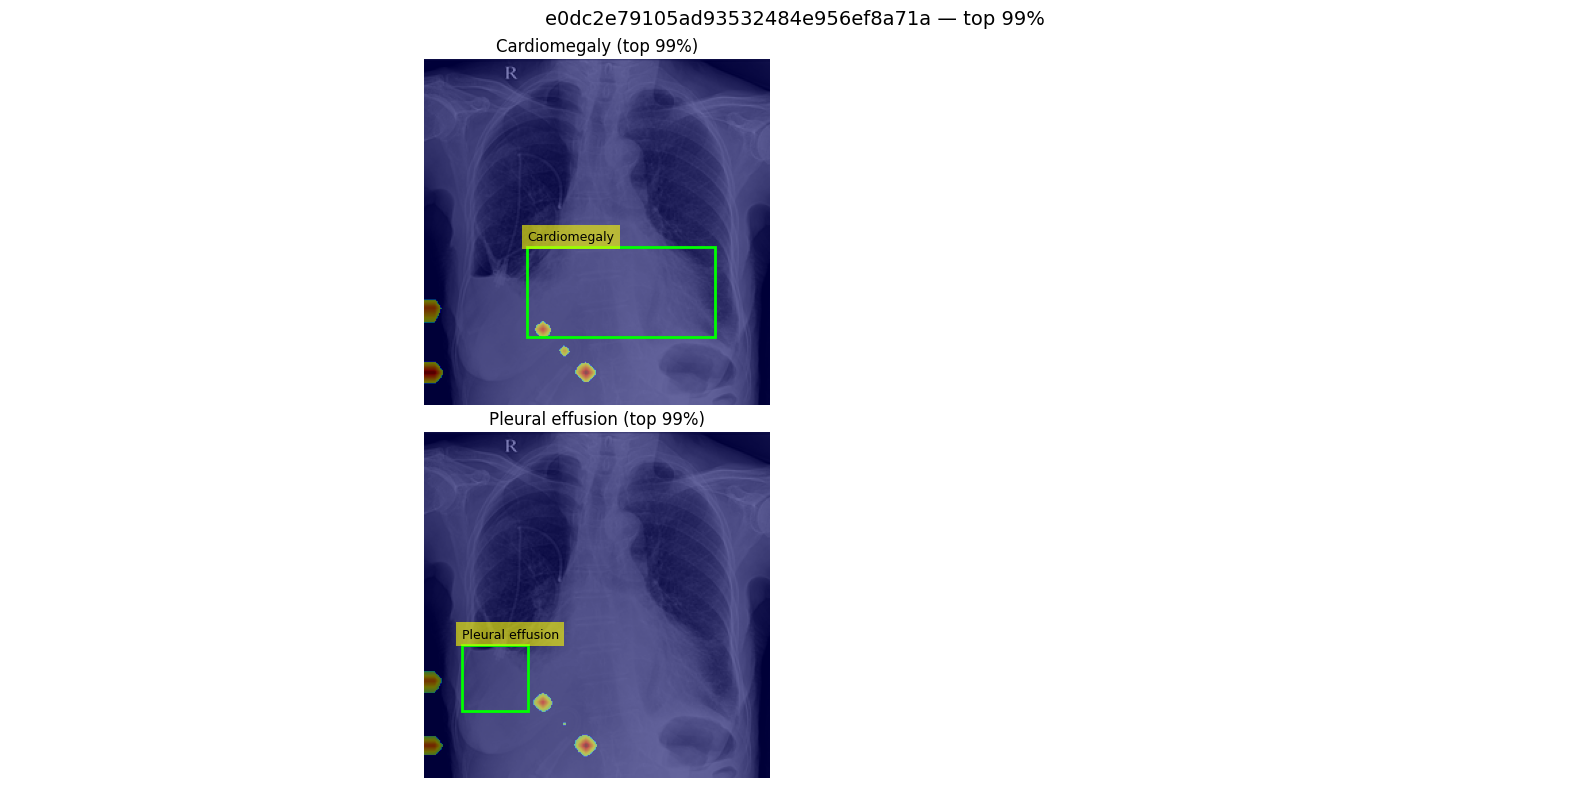

In [10]:
visualize_heatmaps_and_gt_per_label_percentile(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv=annotations_csv,
    meta_csv=meta_csv,
    heatmaps_root=heatmaps_root,
    percentile=99
)